Задача этого ноутбука --- подготовить все компоненты для тренировки visual models (TinyImageNet,resnet18)  на датасетах (CIFAR10, CIFAR100, SVHN) с логгированием, чтобы потом переписать как проект.

Из чего будет состоять ноутбук:

1. модель + ее обуртка? (from HF)
2. данные: загрузка и предобработка
3. метрики: ACC + Expected Calibration Error (и, мб, другие)
4. логирование (будет с помощью neptune) + сохранение чекпоинтов

Источники, из которых брался код:

1. https://github.com/kuangliu/pytorch-cifar/blob/master/main.py
2. [здесь](https://github.com/stat-ml/uncertainty_from_proper_scoring_rules/blob/main/source/datasets/transforms.py) все трансформации хорошо структурированы

### 1. Загрузка данных, создание train и test даталоадеров

In [ ]:
!pip install torchmetrics

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchmetrics.classification import MulticlassCalibrationError
from torchmetrics.classification import MulticlassAccuracy
from tqdm.auto import tqdm

In [ ]:
# Define a transform to normalize the data

transform_train_with_augs = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


BATCH_SIZE = 256

# Load the training dataset
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train_with_augs
)

# Create a DataLoader for the training dataset
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

# Load the test dataset
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)

# Create a DataLoader for the test dataset
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

# Define the classes in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:18<00:00, 9.15MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2. Создание модели (ее код)

У каждой модели будут, помимо основных из `nn.Module` следующие функции и параметры:

1. device
2. loss

Loss-функция принимает на вход (predict, output) и возвращает лосс. Меняем лосс!

Как делать loss-функции на примере в [этом](https://github.com/stat-ml/uncertainty_from_proper_scoring_rules/blob/main/source/losses/losses.py) репозитории

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from losses import *
from models import *
from training_functions import *

In [11]:
from models import *
from training_functions import *

In [12]:
model = ResNet18()
print(f'Model parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.3f}M')

Model parameters: 11.174M


### 3. Метрики и логирование в neptune с чекпоинтами

In [13]:
model_params = {}

model, optimizer = create_model_and_optimizer(
    model_class=ResNet18,
    model_params=model_params,
    lr = 3e-4
)
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1.0)

In [14]:
!pip install neptune -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.2 MB/s eta 0:00:00


In [16]:
import neptune
import functools

### Эксперимент с разными eps на Cross Entropy loss с uniform добавкой

eps_s = [0.01, 0.1, 0.5, 1.0]

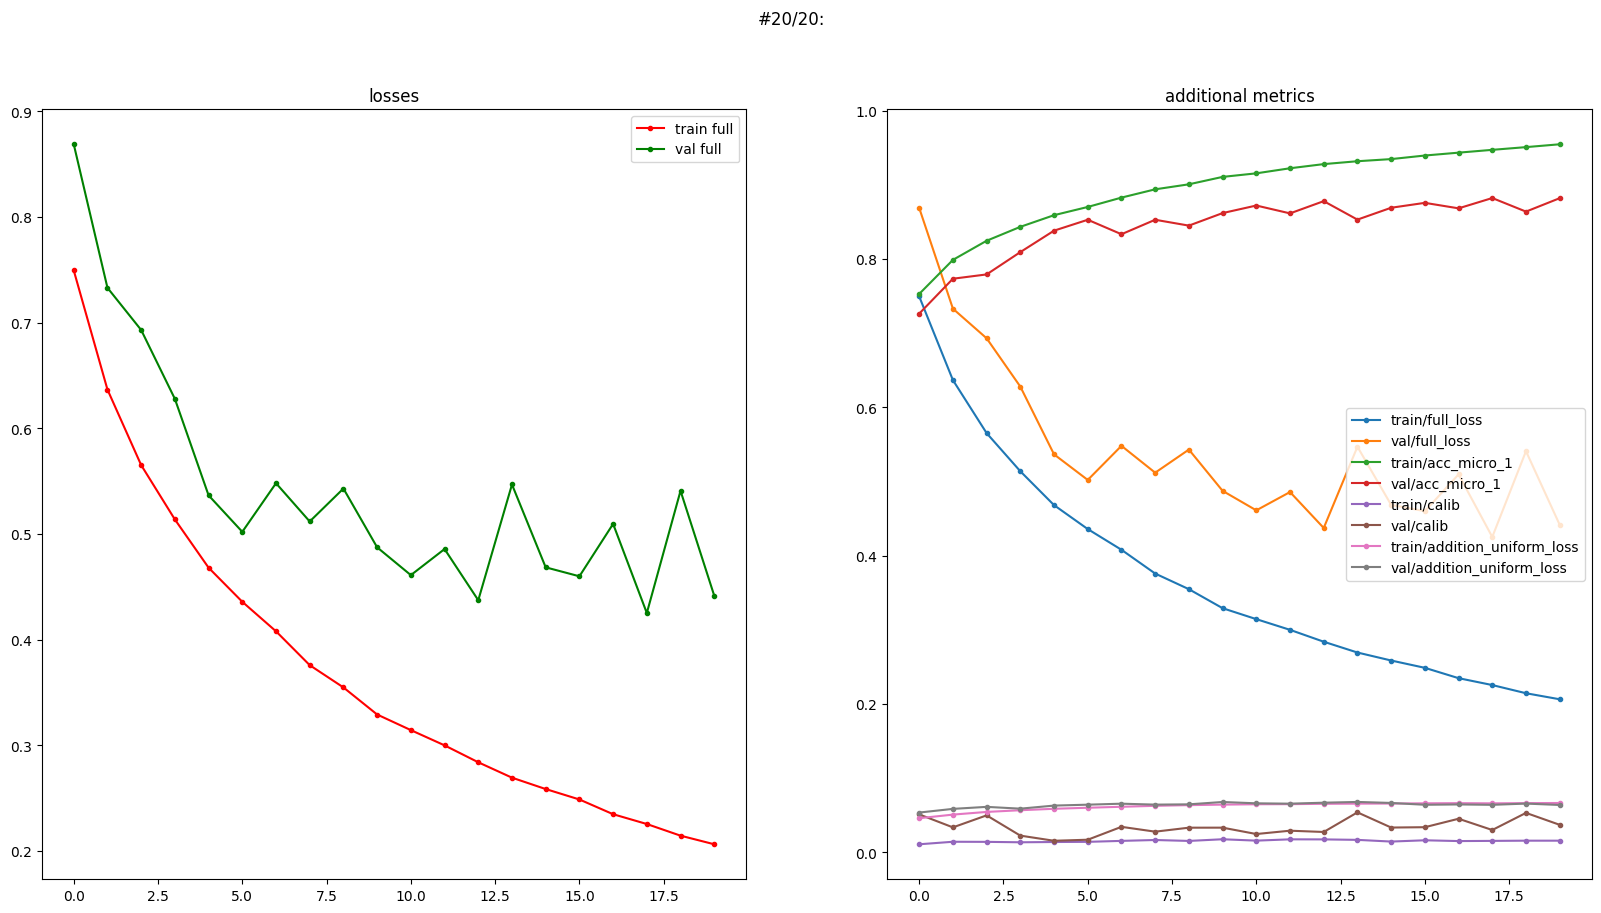

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/e2001092236e/Uncertainty/e/UN-12/metadata


In [ ]:
# run_id = 'UN-12'
eps = 0.01
run = neptune.init_run(
    project="e2001092236e/Uncertainty",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGYzYjI3OS0xZjAyLTRmMmMtOTcwNi04MGE0Y2FlODBjNjMifQ==",
    name="Epsilon change",
    description="how eps influence the whole process",
    # with_id=f"EPS={eps:.2f}"
)  # your credentials


params = {"learning_rate": 3e-4,
          "optimizer": "Adam",
          "model_name": "resnet_18",
          "scheduler": "no",
          "loss": "CE",
          "addition": "uniform",
          "eps": eps
}

run["parameters"] = params

DEVICE = 'cuda'
learning_loop(model,
              optimizer,
              trainloader,
              testloader,
              get_ohe_ce_risk,
              functools.partial(get_uniform_approx_ce_addition, eps=eps),
              "uniform",
              scheduler,
              epochs=20,
              val_every=1,
              draw_every=1,
              model_name='resnet-18 uniform addition',
              metric_names = ['full_loss', 'acc_micro_1', 'calib', 'addition_uniform_loss'],
              run=run)

run.stop()

In [ ]:
# run_id = 'UN-13'
eps = 0.1
run = neptune.init_run(
    project="e2001092236e/Uncertainty",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGYzYjI3OS0xZjAyLTRmMmMtOTcwNi04MGE0Y2FlODBjNjMifQ==",
    name="Epsilon change",
    description="how eps influence the whole process",
    # with_id=f"EPS={eps:.2f}"
)  # your credentials


params = {"learning_rate": 3e-4,
          "optimizer": "Adam",
          "model_name": "resnet_18",
          "scheduler": "no",
          "loss": "CE",
          "addition": "uniform",
          "eps": eps
}

run["parameters"] = params

DEVICE = 'cuda'
learning_loop(model,
              optimizer,
              trainloader,
              testloader,
              get_ohe_ce_risk,
              functools.partial(get_uniform_approx_ce_addition, eps=eps),
              "uniform",
              scheduler,
              epochs=20,
              val_every=1,
              draw_every=1,
              model_name='resnet-18 uniform addition',
              metric_names = ['full_loss', 'acc_micro_1', 'calib', 'addition_uniform_loss'],
              run=run)

run.stop()

In [ ]:
# run_id = 'UN-14'
eps = 0.5
run = neptune.init_run(
    project="e2001092236e/Uncertainty",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGYzYjI3OS0xZjAyLTRmMmMtOTcwNi04MGE0Y2FlODBjNjMifQ==",
    name="Epsilon change",
    description="how eps influence the whole process",
    # with_id=f"EPS={eps:.2f}"
)  # your credentials


params = {"learning_rate": 3e-4,
          "optimizer": "Adam",
          "model_name": "resnet_18",
          "scheduler": "no",
          "loss": "CE",
          "addition": "uniform",
          "eps": eps
}

run["parameters"] = params

DEVICE = 'cuda'
learning_loop(model,
              optimizer,
              trainloader,
              testloader,
              get_ohe_ce_risk,
              functools.partial(get_uniform_approx_ce_addition, eps=eps),
              "uniform",
              scheduler,
              epochs=20,
              val_every=1,
              draw_every=1,
              model_name='resnet-18 uniform addition',
              metric_names = ['full_loss', 'acc_micro_1', 'calib', 'addition_uniform_loss'],
              run=run)

run.stop()

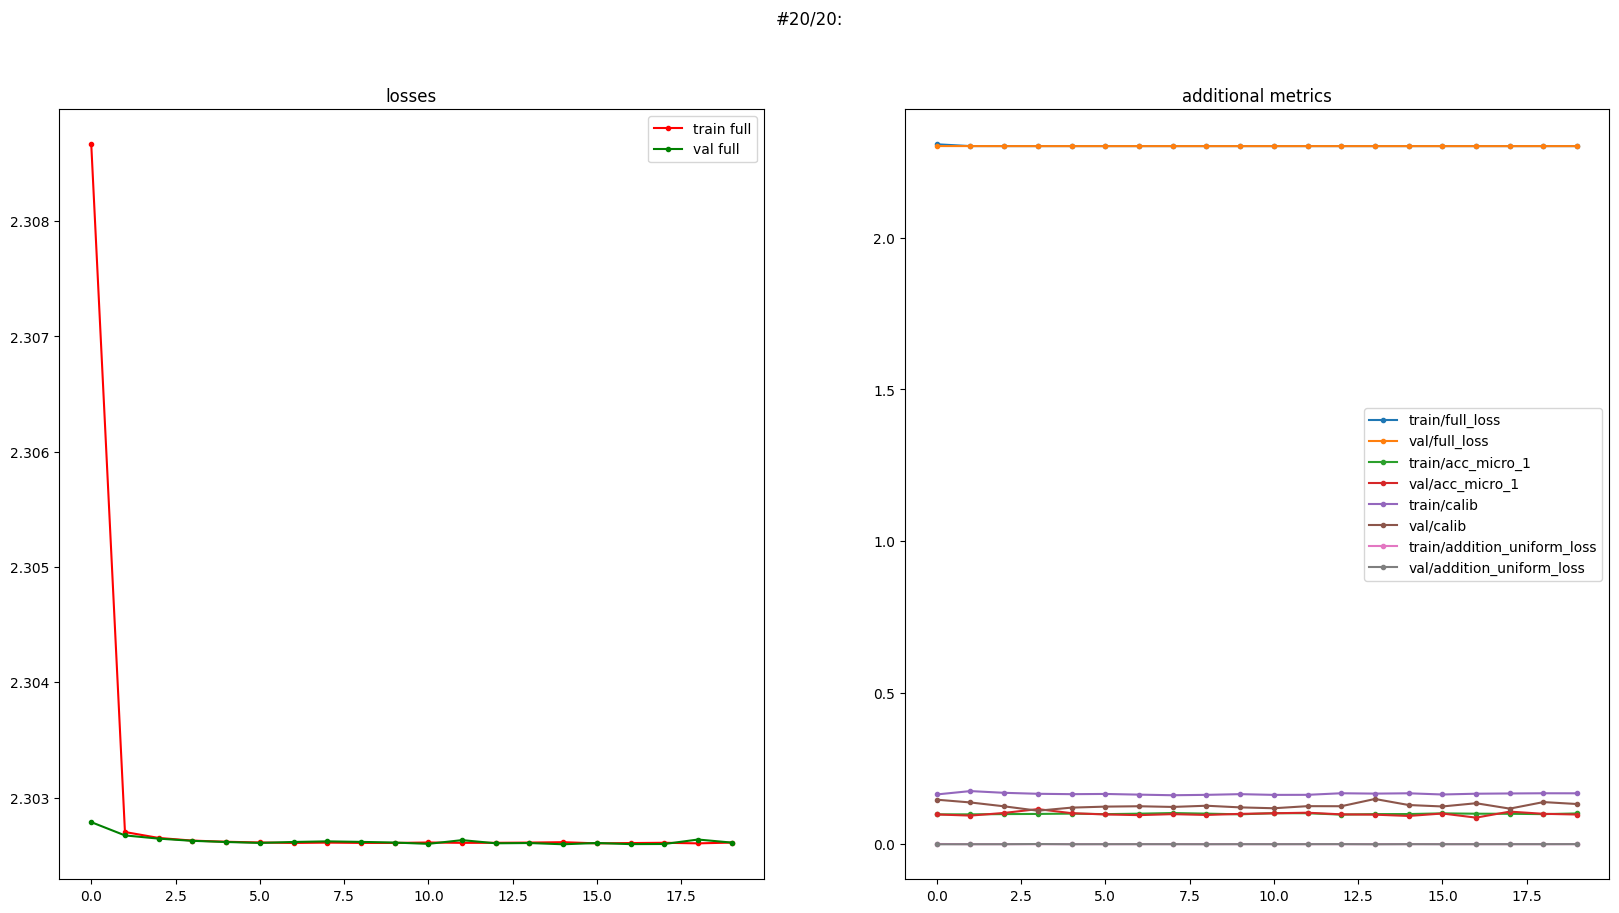

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/e2001092236e/Uncertainty/e/UN-16/metadata


In [ ]:
model_params = {}

model, optimizer = create_model_and_optimizer(
    model_class=ResNet18,
    model_params=model_params,
    lr = 3e-4
)
scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1.0)

# run_id = 'UN-15'
eps = 1.0
run = neptune.init_run(
    project="e2001092236e/Uncertainty",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGYzYjI3OS0xZjAyLTRmMmMtOTcwNi04MGE0Y2FlODBjNjMifQ==",
    name="Epsilon change",
    description="how eps influence the whole process",
    # with_id=f"EPS={eps:.2f}"
)  # your credentials


params = {"learning_rate": 3e-4,
          "optimizer": "Adam",
          "model_name": "resnet_18",
          "scheduler": "no",
          "loss": "CE",
          "addition": "uniform",
          "eps": eps
}

run["parameters"] = params

DEVICE = 'cuda'
learning_loop(model,
              optimizer,
              trainloader,
              testloader,
              get_ohe_ce_risk,
              functools.partial(get_uniform_approx_ce_addition, eps=eps),
              "uniform",
              scheduler,
              epochs=20,
              val_every=1,
              draw_every=1,
              model_name='resnet-18 uniform addition_',
              metric_names = ['full_loss', 'acc_micro_1', 'calib', 'addition_uniform_loss'],
              run=run)

run.stop()

### Эксперименты c и без addition.

Так как в UN-12 (eps=0.01) ECE на val больше, чем на train (норм. обучение), а в UN-13 (eps=0.1) уже наоборот, то принято решение взять

$EPS = 0.03$

In [ ]:
eps = 0.03

#### CE loss

In [ ]:
model_params = {}

model, optimizer = create_model_and_optimizer(
    model_class=ResNet18,
    model_params=model_params,
    lr = 3e-4
)

model_2, optimizer_2 = create_model_and_optimizer(
    model_class=ResNet18,
    model_params=model_params,
    lr = 3e-4
)

scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1.0)


In [ ]:
learning_loop_double(model,
                     model_2,
              optimizer,
              optimizer_2,
              trainloader,
              testloader,
              get_ohe_ce_risk,
              functools.partial(get_uniform_approx_ce_addition, eps=eps),
              "uniform",
              scheduler,
              epochs=2,
              val_every=1,
              draw_every=1,
              model_name='resnet-18 uniform additio_',
              metric_names = ['full_loss', 'acc_micro_1', 'calib', 'addition_uniform_loss'],
              run=None)

#1/2:


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e05ac3cab90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e05ac3cab90>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e05ac3cab90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/tor

  0%|          | 0/40 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e05ac3cab90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e05ac3cab90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

AttributeError: 'NoneType' object has no attribute 'wait'

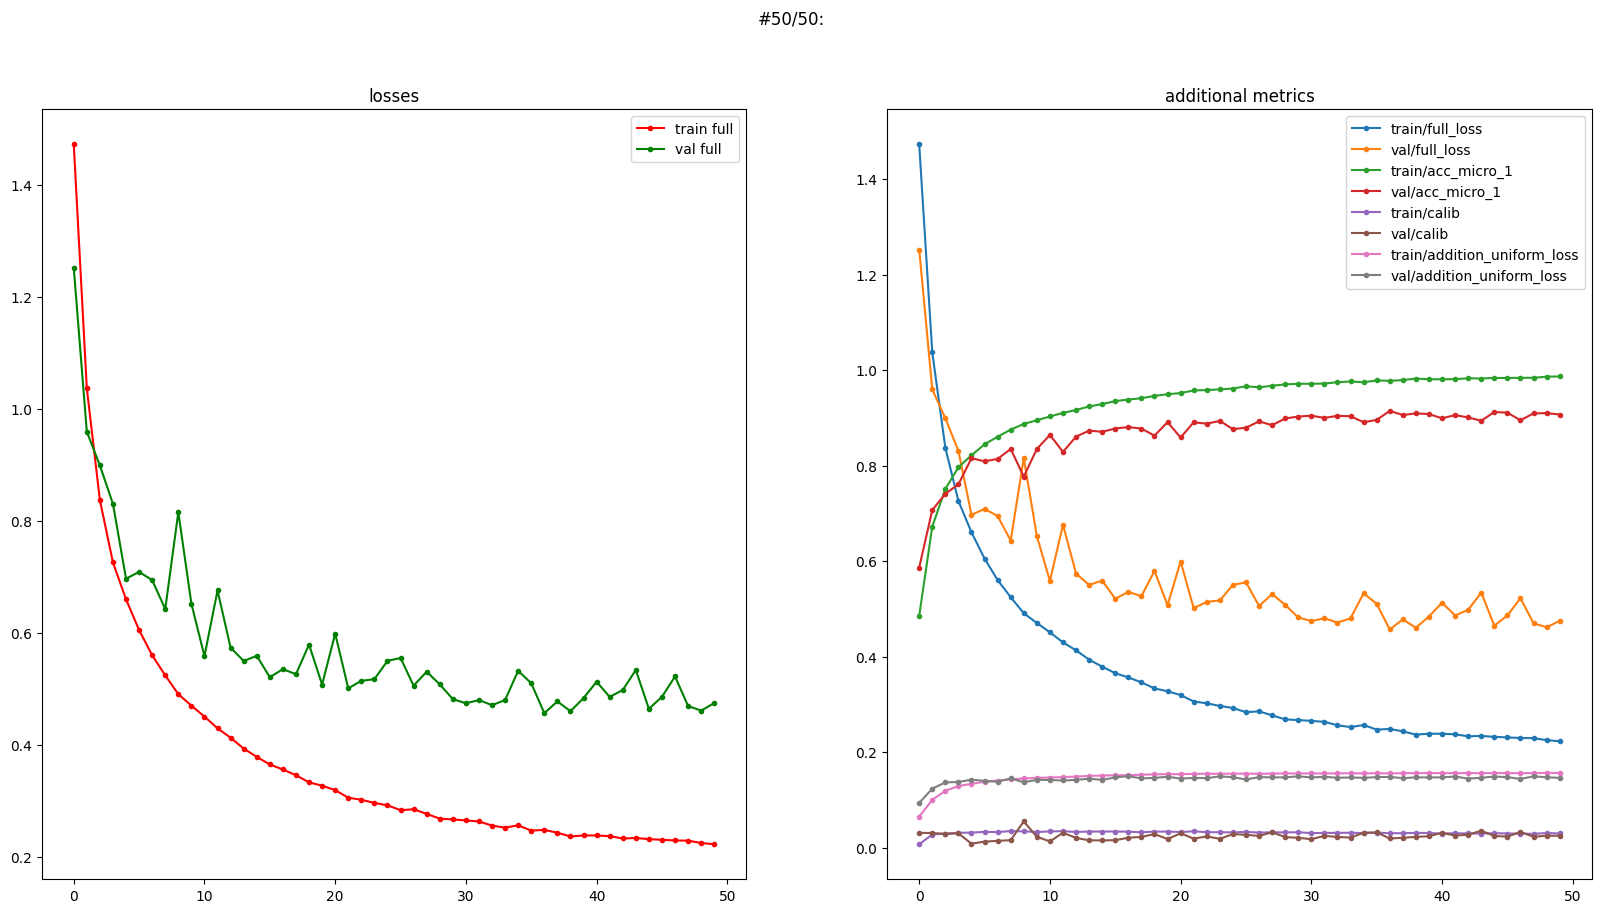

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/e2001092236e/Uncertainty/e/UN-19/metadata


In [ ]:
model_params = {}

model, optimizer = create_model_and_optimizer(
    model_class=ResNet18,
    model_params=model_params,
    lr = 3e-4
)

model_2, optimizer_2 = create_model_and_optimizer(
    model_class=ResNet18,
    model_params=model_params,
    lr = 3e-4
)

scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1.0)

# run_id = 'UN-15'
run = neptune.init_run(
    project="e2001092236e/Uncertainty",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGYzYjI3OS0xZjAyLTRmMmMtOTcwNi04MGE0Y2FlODBjNjMifQ==",
    name="With/without",
)  # your credentials


params = {"learning_rate": 3e-4,
          "optimizer": "Adam",
          "model_name": "resnet_18",
          "scheduler": "no",
          "loss": "CE",
          "addition": "uniform",
          "eps": eps
}

run["parameters"] = params

DEVICE = 'cuda'
learning_loop_double(model,
                     model_2,
              optimizer,
              optimizer_2,
              trainloader,
              testloader,
              get_ohe_ce_risk,
              functools.partial(get_uniform_approx_ce_addition, eps=eps),
              "uniform",
              scheduler,
              epochs=50,
              val_every=1,
              draw_every=1,
              model_name='resnet-18 uniform addition_with_sno',
              metric_names = ['full_loss', 'acc_micro_1', 'calib', 'addition_uniform_loss'],
              run=run)

run.stop()

In [ ]:
from collections import Counter

freqs = np.zeros(shape=(10, ))
train_classes = [item[1] for item in tqdm(trainset)]

for tr_cl in train_classes:
    freqs[tr_cl] += 1

freqs = torch.FloatTensor(freqs) / len(train_classes)

  0%|          | 0/50000 [00:00<?, ?it/s]

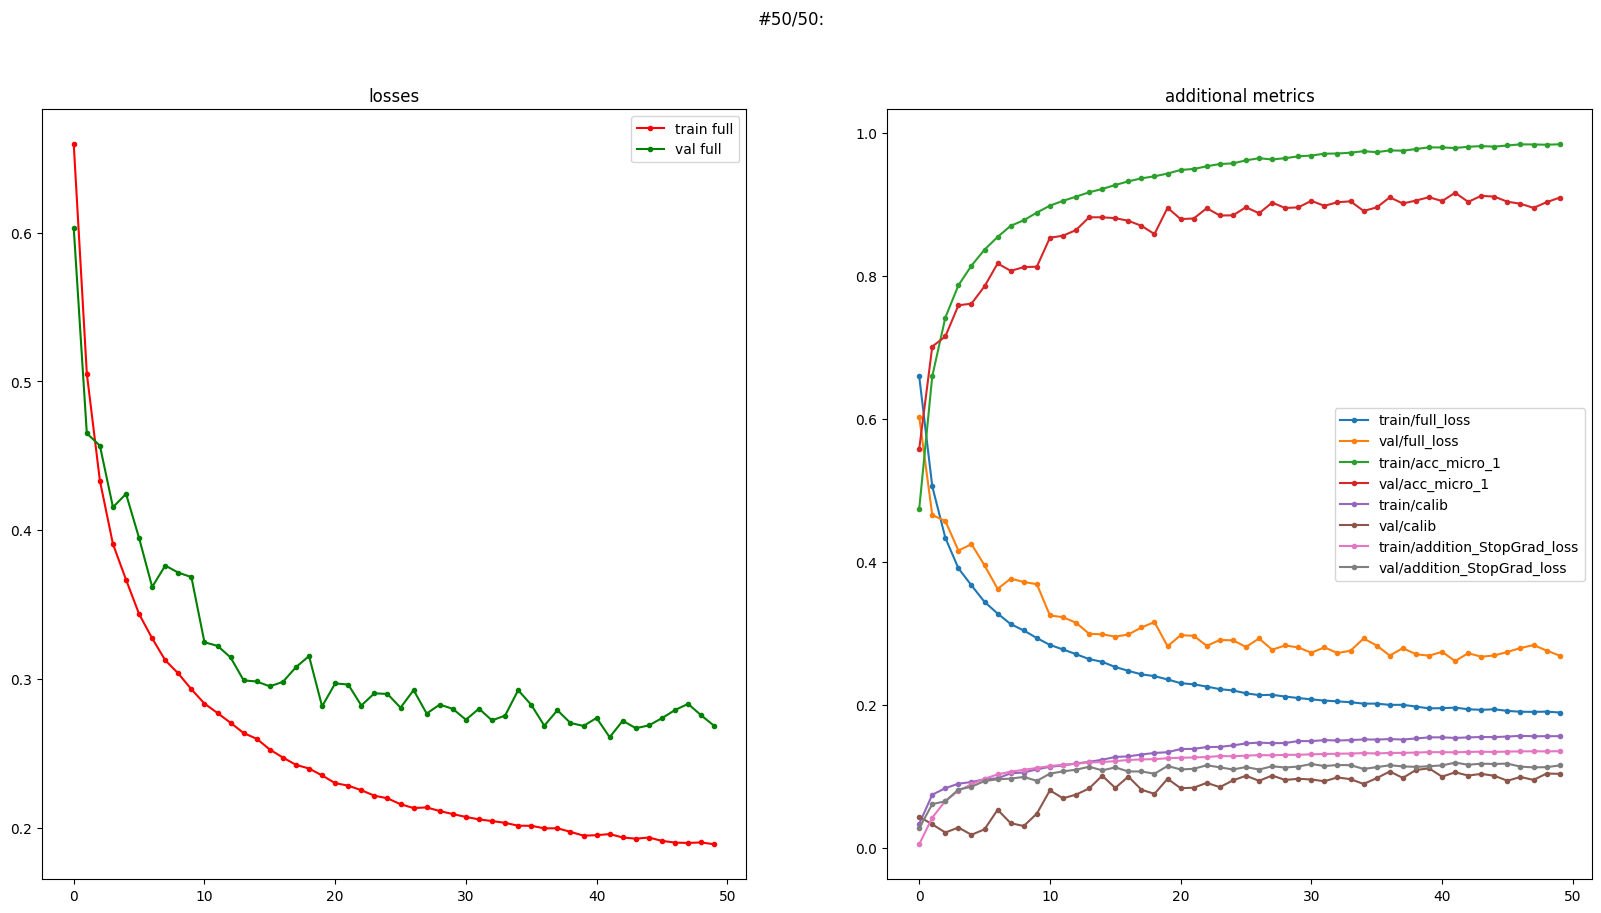

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/e2001092236e/Uncertainty/e/UN-27/metadata


In [ ]:
### ЗАПУСТИТЬ!!!
eps = 0.1

model_params = {}

model, optimizer = create_model_and_optimizer(
    model_class=ResNet18,
    model_params=model_params,
    lr = 3e-4
)

model_2, optimizer_2 = create_model_and_optimizer(
    model_class=ResNet18,
    model_params=model_params,
    lr = 3e-4
)

scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1.0)

# run_id = 'UN-15'
run = neptune.init_run(
    project="e2001092236e/Uncertainty",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGYzYjI3OS0xZjAyLTRmMmMtOTcwNi04MGE0Y2FlODBjNjMifQ==",
    name="With/without",
)  # your credentials


params = {"learning_rate": 3e-4,
          "optimizer": "Adam",
          "model_name": "resnet_18",
          "scheduler": "no",
          "loss": "brier",
          "addition": "StopGrad",
          "eps": eps
}

run["parameters"] = params

DEVICE = 'cuda'
learning_loop_double(model,
                     model_2,
              optimizer,
              optimizer_2,
              trainloader,
              testloader,
              get_ohe_brier_risk,
              functools.partial(get_stopgrad_brier_addition, freqs=freqs, eps=eps), # get_prior_approx_brier_addition, freqs=freqs
              "StopGrad",
              scheduler,
              epochs=50,
              val_every=1,
              draw_every=1,
              model_name='resnet-18 uniform additidon_with_gsno',
              metric_names = ['full_loss', 'acc_micro_1', 'calib', 'addition_StopGrad_loss'],
              run=run)

run.stop()

In [ ]:
DEVICE = 'cuda'
learning_loop(model,
              optimizer,
              trainloader,
              testloader,
              get_ohe_ce_risk,
              functools.partial(get_uniform_approx_ce_addition, eps=0.01),
              "uniform",
              scheduler,
              epochs=30,
              val_every=1,
              draw_every=1,
              model_name='resnet-18 uniform addition',
              metric_names = ['full_loss', 'acc_micro_1', 'calib', 'addition_uniform_loss'],
              run=run)

In [ ]:
import neptune

run = neptune.init_run(
    project="e2001092236e/Uncertainty",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxMGYzYjI3OS0xZjAyLTRmMmMtOTcwNi04MGE0Y2FlODBjNjMifQ==",
)  # your credentials

params = {"learning_rate": 3e-4,
          "optimizer": "Adam",
          "model_name": "resnet_18",
          "scheduler": "no",
          "loss": "brier",
          "addition": "prior (=uniform)",
}
run["parameters"] = params


[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/e2001092236e/Uncertainty/e/UN-9


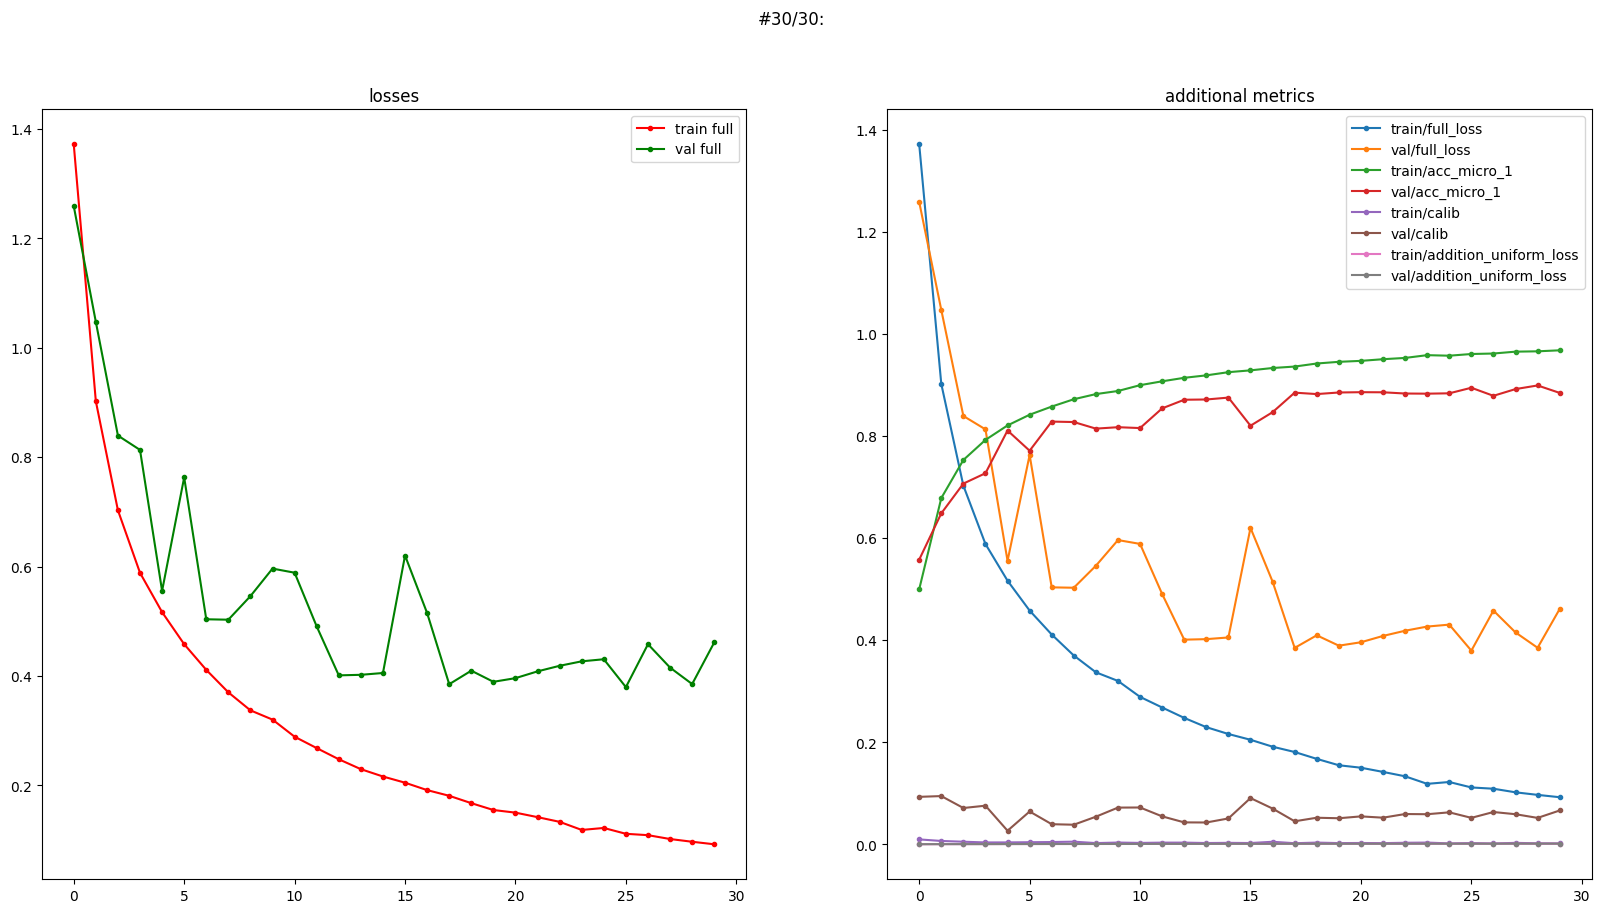

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (shortcut): Sequential()
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momen

In [ ]:
DEVICE = 'cuda'
learning_loop(model,
              optimizer,
              trainloader,
              testloader,
              get_ohe_ce_risk,
              get_uniform_approx_ce_addition,
              "uniform",
              scheduler,
              epochs=30,
              val_every=1,
              draw_every=1,
              model_name='resnet-18 uniform addition',
              metric_names = ['full_loss', 'acc_micro_1', 'calib', 'addition_uniform_loss'],
              run=run)

In [ ]:
run['val/acc_micro_1'].fetch_values()

,step,value,timestamp
0,0.0,0.5580,2024-12-04 08:17:18.518
1,1.0,0.6487,2024-12-04 08:18:19.116
2,2.0,0.7070,2024-12-04 08:19:37.377
3,3.0,0.7273,2024-12-04 08:20:46.731
4,4.0,0.8110,2024-12-04 08:22:04.763
5,5.0,0.7714,2024-12-04 08:23:24.028
6,6.0,0.8285,2024-12-04 08:24:39.305
7,7.0,0.8276,2024-12-04 08:25:49.583
8,8.0,0.8147,2024-12-04 08:26:49.422
9,9.0,0.8175,2024-12-04 08:27:55.268


In [ ]:
run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/e2001092236e/Uncertainty/e/UN-8/metadata


Brier Loss + Brier prior (= uniform) addition

In [ ]:
from collections import Counter

freqs = np.zeros(shape=(10, ))
train_classes = [item[1] for item in tqdm(trainset)]

for tr_cl in train_classes:
    freqs[tr_cl] += 1

freqs = torch.FloatTensor(freqs) / len(train_classes)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
from functools import partial

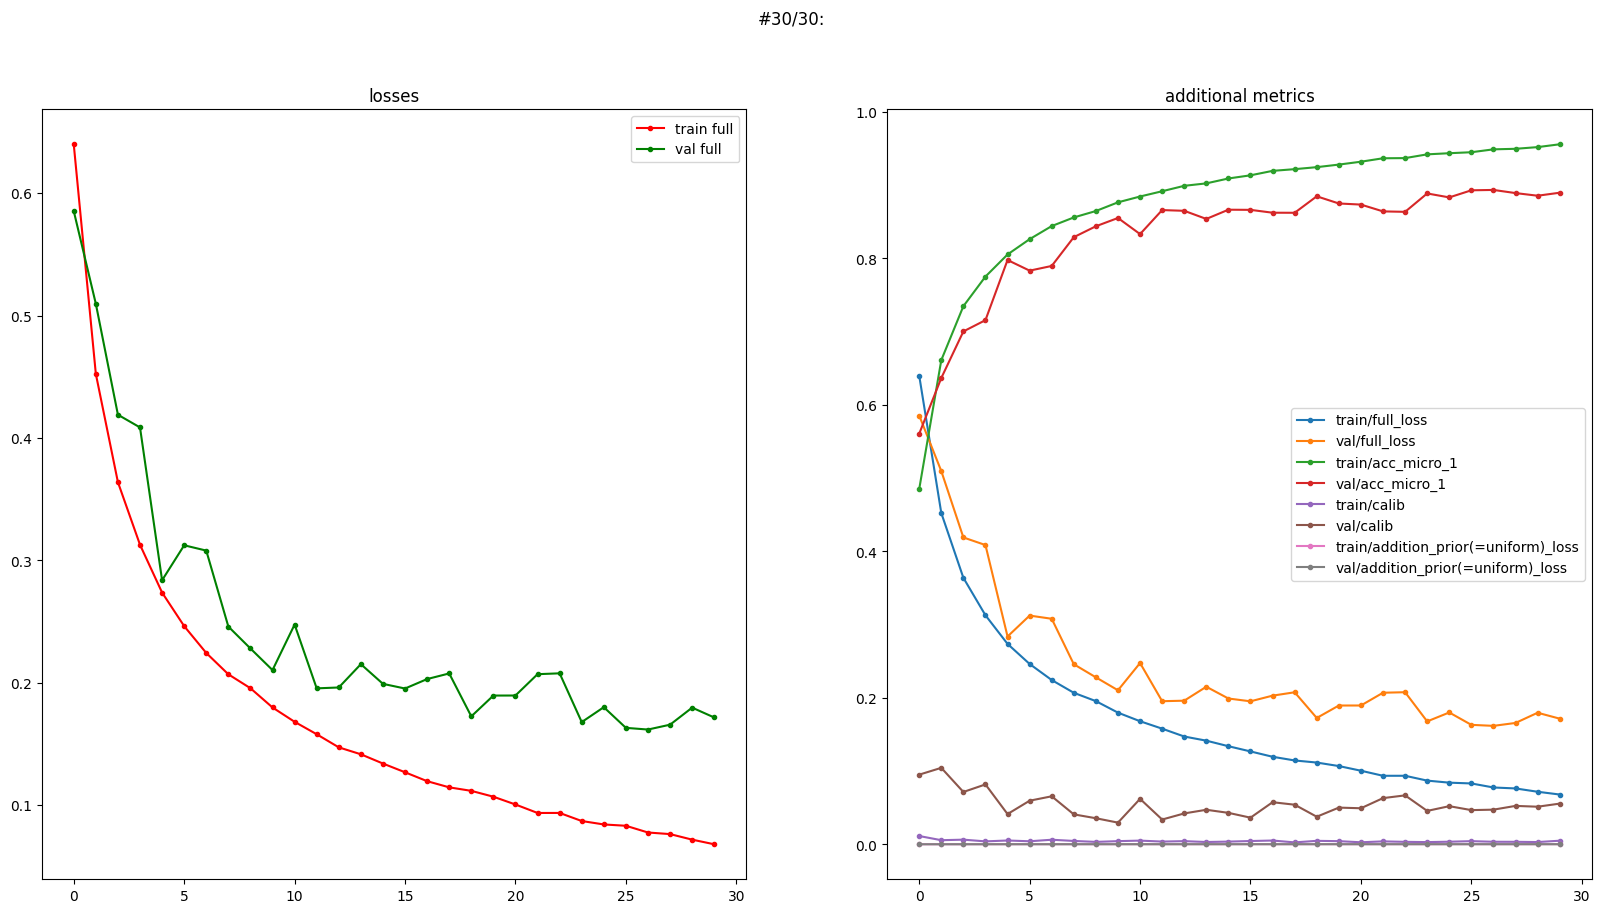

(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (shortcut): Sequential()
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momen

In [ ]:
DEVICE = 'cuda'
learning_loop(model,
              optimizer,
              trainloader,
              testloader,
              get_ohe_brier_risk,
              partial(get_prior_approx_brier_addition, freqs=freqs, eps=1e-4),
              "prior(=uniform)",
              scheduler,
              epochs=30,
              val_every=1,
              draw_every=1,
              model_name='resnet-18 brier + prior(=uniform) addition_',
              metric_names = ['full_loss', 'acc_micro_1', 'calib', 'addition_prior(=uniform)_loss'],
              run=run)